# 打乱训练集的代码

In [3]:
import json
import random

#设置随机种子
random.seed(0)
with open('/root/paddlejob/workspace/env_run/data/msmarco-pass/repllama-train-tevatron_1.jsonl', 'w', encoding="utf-8") as file:
    #打开你的文件
    with open('/root/paddlejob/workspace/env_run/data/msmarco-pass/repllama-train-tevatron.jsonl', "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            random.shuffle(data['positive_passages'])
            random.shuffle(data['negative_passages'])
            file.write(json.dumps(data)+"\n")

# 提取有答案的训练集代码

In [ ]:
def get_answers():
    id_answers = {}
    with open("/root/paddlejob/workspace/env_run/output/train_final.jsonl", "r", encoding="utf-8") as file:
        for line in file:
            js = json.loads(line)
            id_answers[js["query_id"]] = js["answers"][0]
    return id_answers
def get_passage_ids():
    id_answers = get_answers()
    id_passages = {}
    id_query = {}
    num = 0
    num_1 = 0
    with open("/root/paddlejob/workspace/env_run/data/msmarco-pass/repllama-train-tevatron-filter.jsonl", "w", encoding="utf-8") as file_w:
        with open("/root/paddlejob/workspace/env_run/data/msmarco-pass/repllama-train-tevatron_1.jsonl", "r", encoding="utf-8") as file:
            for line in file:
                js = json.loads(line)
                query_id = js["query_id"]
                if query_id not in id_answers:
                    num += 1
                    continue
                else:
                    num_1 += 1
                    file_w.write(json.dumps(js)+"\n")


    print(num)
    print(num_1)
                
get_passage_ids()

In [21]:
import json
import re
with open("../Qwen-utility-selection-gt-answer-add_generation_prompt-final.jsonl", "w", encoding="utf-8") as file_w:
    with open("../Qwen-utility-selection-gt-answer-add_generation_prompt.jsonl", "r", encoding="utf-8") as file_r:
        for line in file_r:
            js = json.loads(line)
            numbers = re.findall(r'\[(\d+)\]', js["utility_selection"])
            numbers = [int(number)-1 for number in numbers]
            utility_scores = [0]*len(js["passages_ids"])
            for number in numbers:
                if number >= len(utility_scores):
                    continue
                utility_scores[number]=1
            js["utility_score"] = utility_scores
            file_w.write(json.dumps(js)+"\n")
        file_r.close()
        

In [ ]:
import json
import re
id_scores = {}
real_num = 0
with open("../Qwen-relevance-selection-first-add_generation_prompt-relevance_utility-final.jsonl", "w", encoding="utf-8") as file_w:
    with open("../test.jsonl", "r", encoding="utf-8") as file_r:
        for line in file_r:
            js = json.loads(line)
            numbers = re.findall(r'\[(\d+)\]', js["relevance_output"])
            numbers = [int(number)-1 for number in numbers]
            utility_scores = [0]*len(js["passages_ids"])
            for number in numbers:
                if number >= len(utility_scores):
                    continue
                utility_scores[number]=1
            js["relevance_score"] = utility_scores
            id_scores[js["query_id"]] = utility_scores
            file_w.write(json.dumps(js)+"\n")
            real_num += 1
        file_r.close()
same_num = 0
with open("../Qwen-relevance-selection-first-add_generation_prompt-final.jsonl", "r", encoding="utf-8") as file_r:
    for line in file_r:
        js = json.loads(line)
        if js["query_id"] in id_scores:
            if id_scores[js["query_id"]] == js["relevance_score"]:
                same_num+= 1
                continue
            # else:
            #     print(id_scores[js["query_id"]])
            #     print(js["relevance_score"])
            #     print("---------------------------------------")
print("same: ", same_num)
print("error_num: ", real_num-same_num)
print("all_num: ", real_num)
print("error_num ratio: ", 100*(real_num-same_num)/real_num)
        

# 统计relevance selection数量和召回的代码

postive recall:  0.9275244548448393
avg length:  6.191068559104045
null nums:  5844


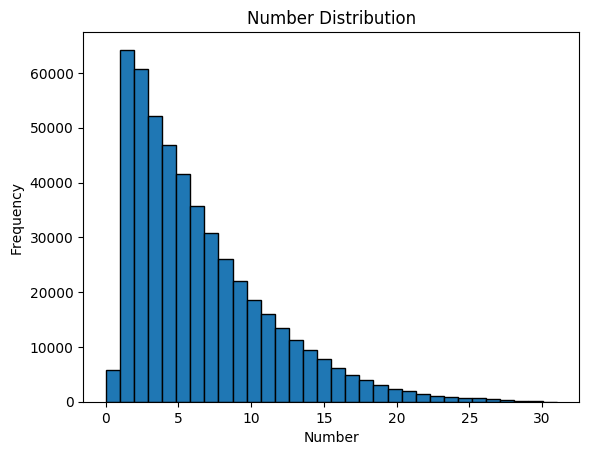

In [16]:
import json 
file_r = open("../Qwen-relevance-label_add_generation_prompt.jsonl", "r", encoding="utf-8")
recall = []
nums = []
for line in file_r:
    js = json.loads(line)
    relevance_score = js['relevance_score']
    recall.append(1 if relevance_score[0] == 1 else 0)
    nums.append(sum(relevance_score))

print("postive recall: ", sum(recall)/len(recall))
print("avg length: ", sum(nums)/len(nums))
print("null nums: ", nums.count(0))
import matplotlib.pyplot as plt

plt.hist(nums, bins=max(nums)+1,  edgecolor='black')

plt.title("Number Distribution")
plt.xlabel("Number")
plt.ylabel("Frequency")
plt.savefig("img/relevance_number_distribution.pdf")
plt.show()

postive recall:  0.8973879494904434
avg length:  1.8074725462756434
null nums:  31963


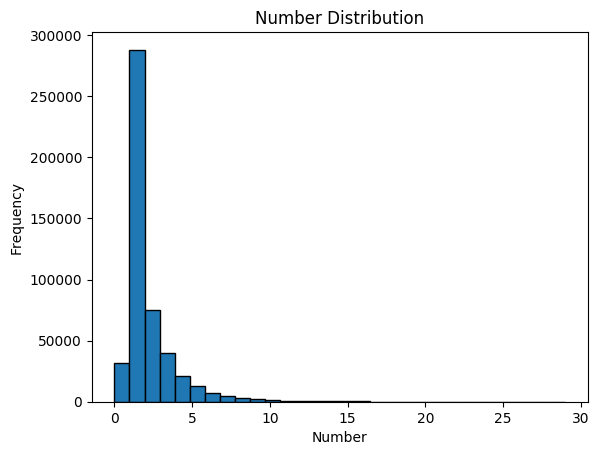

In [22]:
import json 
file = open("../Qwen-relevance-label_add_generation_prompt.jsonl", "r", encoding="utf-8")
gt_label = {}
for line in file:
    js = json.loads(line)
    gt_label[js["query_id"]] = js["passages_ids"]
    
file_r = open("../Qwen-utility-selection-gt-answer-add_generation_prompt-final.jsonl", "r", encoding="utf-8")
recall = []
nums = []
for line in file_r:
    js = json.loads(line)
    utility_ids = []
    flag = 0
    for index, score in enumerate(js["utility_score"]):
        if score == 1 and js["passages_ids"][index] == gt_label[js["query_id"]][0]:
            flag = 1
    recall.append(flag)
    
    nums.append(sum(js["utility_score"]))
    

print("postive recall: ", sum(recall)/len(recall))
print("avg length: ", sum(nums)/len(nums))
print("null nums: ", nums.count(0))
import matplotlib.pyplot as plt

plt.hist(nums, bins=max(nums)+1,  edgecolor='black')
plt.title("Number Distribution")
plt.xlabel("Number")
plt.ylabel("Frequency")
plt.savefig("img/utility_gt_answer_number_distribution.pdf")
plt.show()

postive recall:  0.8484461524988443
avg length:  2.891158374524192
null nums:  9989


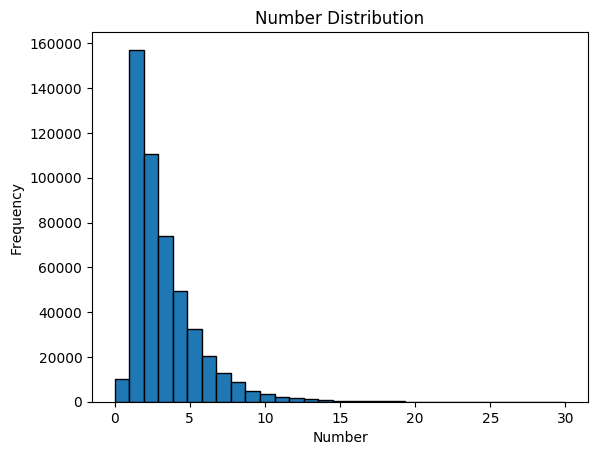

In [23]:
import json 
file = open("../Qwen-relevance-label_add_generation_prompt.jsonl", "r", encoding="utf-8")
gt_label = {}
for line in file:
    js = json.loads(line)
    gt_label[js["query_id"]] = js["passages_ids"]
    
file_r = open("../Qwen-utility-selection-add_generation_prompt-final.jsonl", "r", encoding="utf-8")
recall = []
nums = []
for line in file_r:
    js = json.loads(line)
    utility_ids = []
    flag = 0
    for index, score in enumerate(js["utility_score"]):
        if score == 1 and js["passages_ids"][index] == gt_label[js["query_id"]][0]:
            flag = 1
    recall.append(flag)
    
    nums.append(sum(js["utility_score"]))
    

print("postive recall: ", sum(recall)/len(recall))
print("avg length: ", sum(nums)/len(nums))
print("null nums: ", nums.count(0))
import matplotlib.pyplot as plt

plt.hist(nums, bins=max(nums)+1,  edgecolor='black')

plt.title("Number Distribution")
plt.xlabel("Number")
plt.ylabel("Frequency")
plt.savefig("img/utility_number_distribution.pdf")
plt.show()

# relevance selection合并的代码

In [ ]:
import json
relevance_score_set = {}
passages_ids_set = {}
with open("Qwen-relevance-selection-first-final.jsonl", "r", encoding="utf-8") as file_r:
    for line in file_r:
        js = json.loads(line)
        query_id = js["query_id"]
        relevance_score = js["relevance_score"]
        relevance_score_set[query_id] = relevance_score
        passages_ids = js["passages_ids"]
        passages_ids_set[query_id] = passages_ids
with open("Qwen-relevance-label.jsonl", "w", encoding="utf-8") as file_w:
    with open("Qwen-relevance-selection-last-final.jsonl", "r", encoding="utf-8") as file_r:
        for line in file_r:
            js = json.loads(line)
            query_id = js["query_id"]
            relevance_score_first = relevance_score_set[query_id]
            relevance_score_last = js["relevance_score"]
            passages_ids_first = passages_ids_set[query_id]
            passages_ids_last = js["passages_ids"]
            js_new = {
                "query_id": query_id, 
                "passages_ids": passages_ids_first+passages_ids_last[1:], 
                "relevance_score": relevance_score_first+relevance_score_last[1:]
            }
            file_w.write(json.dumps(js_new)+"\n")


In [9]:

import json
import re

with open("../Qwen-relevance-selection-first-relevance_utility_add_generation_prompt_final.jsonl", "w", encoding="utf-8") as file_w:
    with open("../Qwen-relevance-selection-first-relevance_utility_add_generation_prompt.jsonl", "r", encoding="utf-8") as file_r:
        for line in file_r:
            js = json.loads(line)
            numbers = re.findall(r'\[(\d+)\]', js["relevance_output"])
            numbers = [int(number)-1 for number in numbers]
            utility_scores = [0]*len(js["passages_ids"])
            for number in numbers:
                if number >= len(utility_scores):
                    continue
                utility_scores[number]=1
            js["relevance_score"] = utility_scores
            file_w.write(json.dumps(js)+"\n")
        file_r.close()


with open("../Qwen-relevance-selection-last-relevance_utility_add_generation_prompt_final.jsonl", "w", encoding="utf-8") as file_w:
    with open("../Qwen-relevance-selection-last-relevance_utility_add_generation_prompt.jsonl", "r", encoding="utf-8") as file_r:
        for line in file_r:
            js = json.loads(line)
            numbers = re.findall(r'\[(\d+)\]', js["relevance_output"])
            numbers = [int(number)-1 for number in numbers]
            utility_scores = [0]*len(js["passages_ids"])
            for number in numbers:
                if number >= len(utility_scores):
                    continue
                utility_scores[number]=1
            js["relevance_score"] = utility_scores
            file_w.write(json.dumps(js)+"\n")
        file_r.close()
        
relevance_score_set = {}
passages_ids_set = {}
with open("../Qwen-relevance-selection-first-relevance_utility_add_generation_prompt_final.jsonl", "r", encoding="utf-8") as file_r:
    for line in file_r:
        js = json.loads(line)
        query_id = js["query_id"]
        relevance_score = js["relevance_score"]
        relevance_score_set[query_id] = relevance_score
        passages_ids = js["passages_ids"]
        passages_ids_set[query_id] = passages_ids
with open("../Qwen-relevance-label_relevance_utility.jsonl", "w", encoding="utf-8") as file_w:
    with open("../Qwen-relevance-selection-last-relevance_utility_add_generation_prompt_final.jsonl", "r", encoding="utf-8") as file_r:
        for line in file_r:
            js = json.loads(line)
            query_id = js["query_id"]
            relevance_score_first = relevance_score_set[query_id]
            relevance_score_last = js["relevance_score"]
            passages_ids_first = passages_ids_set[query_id]
            passages_ids_last = js["passages_ids"]
            js_new = {
                "query_id": query_id, 
                "passages_ids": passages_ids_first+passages_ids_last[1:], 
                "relevance_score": relevance_score_first+relevance_score_last[1:]
            }
            file_w.write(json.dumps(js_new)+"\n")


# 处理ranking的代码

In [ ]:
import json
import re
def extract_substrings(input_string):
        pattern = re.compile(r'\[\d+\]')
        substrings = pattern.findall(input_string)
        extracted_string = ''.join(substrings)
        return extracted_string

def clean_response(response: str):
    response = extract_substrings(response)
    new_response = ''
    for c in response:
        if not c.isdigit():
            new_response += ' '
        else:
            new_response += c
    new_response = new_response.strip()
    return new_response


def remove_duplicate(response):
    new_response = []
    for c in response:
        if c not in new_response:
            new_response.append(c)
    return new_response
with open("../Qwen-utility-ranking-add_generation_prompt_final.jsonl", "w", encoding="utf-8") as file_w:
    with open("../Qwen-utility-ranking-add_generation_prompt.jsonl", "r", encoding="utf-8") as file2:
        for line in file2:
            js = json.loads(line)
            relevace_ranking = js["utility_ranking"]
            response = clean_response(relevace_ranking)
            response = [int(x) - 1 for x in response.split()]
            response = remove_duplicate(response)
            response = [i for i in response if i >= 0 and i < len(js["passages_ids"])]
            js["ranking_score"] = response
            ranked_passage_ids = []
            for i in response:
                ranked_passage_ids.append(js["passages_ids"][i])
            js["ranked_passage_ids"] = ranked_passage_ids
            file_w.write(json.dumps(js)+"\n")
